In [75]:
import os
import warnings
import keras
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import newaxis
from keras.layers.core import  Activation, Dropout
from keras.models import Model
from keras.layers import Input, Embedding,LSTM, Dense,TimeDistributed, Reshape
from keras import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate
#from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [76]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [77]:
dataset_stock = read_csv('stock1.csv', header = 0, index_col=0)
values_stock = dataset_stock.values
encoder = LabelEncoder()
values_stock[:,0] = encoder.fit_transform(values_stock[:,0])
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_stock = scaler.fit_transform(values_stock)
reframed_stock = series_to_supervised(scaled_stock, 1, 1)
print(reframed_stock.head())

   var1(t-1)   var1(t)
1   0.157798  0.161468
2   0.161468  0.150459
3   0.150459  0.177982
4   0.177982  0.166972
5   0.166972  0.179817


In [78]:
dataset_gap = read_csv('gap1.csv', header = 0, index_col=0)
values_gap = dataset_gap.values
encoder = LabelEncoder()
values_gap[:,0] = encoder.fit_transform(values_gap[:,0])
values_gap = values_gap.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_gap = scaler.fit_transform(values_gap)
reframed_gap = series_to_supervised(scaled_gap, 1, 1)

print(reframed_gap.head())
#print values_gap

   var1(t-1)   var1(t)
1   0.488038  0.435407
2   0.435407  0.617225
3   0.617225  0.401914
4   0.401914  0.559809
5   0.559809  0.397129


In [79]:
dataset_fai = read_csv('fai1.csv', header = 0, index_col=0)
values_fai = dataset_fai.values
encoder = LabelEncoder()
values_fai[:,0] = encoder.fit_transform(values_fai[:,0])
values_fai = values_fai.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_fai = scaler.fit_transform(values_fai)
reframed_fai = series_to_supervised(scaled_fai, 1, 1)
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis = 1, inplace=True)
print(reframed_fai.head())
#print values_fai

   var1(t-1)   var1(t)
1   0.182609  0.191304
2   0.191304  0.182609
3   0.182609  0.191304
4   0.191304  0.182609
5   0.182609  0.104348


In [80]:
values_stock = reframed_stock.values
n_train_hours = 673
train_stock = values_stock[:n_train_hours, :]

test_stock = values_stock[n_train_hours:, :]

train_X_stock, train_y_stock = train_stock[:,:-1], train_stock[:, -1]

test_stock_X, test_stock_y = test_stock[:,:-1],test_stock[:,-1]

train_X_stock = train_X_stock.reshape((train_X_stock.shape[0], 1, train_X_stock.shape[1]))
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0], 1, test_stock_X.shape[1]))
print(train_X_stock.shape, train_y_stock.shape, test_stock_X.shape, test_stock_y.shape)
print(test_stock_X, test_stock_y)

((673, 1, 1), (673,), (5, 1, 1), (5,))
(array([[[ 0.56146789]],

       [[ 0.50825691]],

       [[ 0.51009172]],

       [[ 0.50091743]],

       [[ 0.48440367]]], dtype=float32), array([ 0.50825691,  0.51009172,  0.50091743,  0.48440367,  0.49541286], dtype=float32))


In [81]:
stock_input = Input(shape=(train_X_stock.shape[1], train_X_stock.shape[2]), dtype='float32', name='stock_input')
#stock_input = Embedding(output_dim=512, input_dim = 10000, input_length=1)(stock_input)

#print lstm_out_stock_embedding
print stock_input

Tensor("stock_input_5:0", shape=(?, 1, 1), dtype=float32)


In [82]:
lstm_out_stock = LSTM(32)(stock_input)
lstm_out_stock_cut = Dense(1)(lstm_out_stock)
lstm_out_stock = Reshape((1,1))(lstm_out_stock_cut)
print lstm_out_stock

Tensor("reshape_7/Reshape:0", shape=(?, 1, 1), dtype=float32)


In [83]:
stock_output = Dense(1, activation='linear', name='stock_output')(lstm_out_stock_cut)

In [84]:
values_gap = reframed_gap.values

n_train_hours = 673
train_gap = values_gap[:n_train_hours, :]

test_gap = values_gap[n_train_hours:, :]

train_X_gap, train_y_gap = train_gap[:,:-1], train_gap[:, -1]

test_gap_X, test_gap_y = test_gap[:,:-1],test_gap[:,-1]

train_X_gap = train_X_gap.reshape((train_X_gap.shape[0], 1, train_X_gap.shape[1]))
test_gap_X = test_gap_X.reshape((test_gap_X.shape[0], 1, test_gap_X.shape[1]))
print(train_X_gap.shape, train_y_gap.shape, test_gap_X.shape, test_gap_y.shape)
print(test_gap_X, test_gap_y)

((673, 1, 1), (673,), (5, 1, 1), (5,))
(array([[[ 0.22009568]],

       [[ 0.48803827]],

       [[ 0.40669855]],

       [[ 0.35406697]],

       [[ 0.56459326]]], dtype=float32), array([ 0.48803827,  0.40669855,  0.35406697,  0.56459326,  0.5119617 ], dtype=float32))


In [85]:
gap_input = Input(shape=(train_X_gap.shape[1], train_X_gap.shape[2]),dtype='float32', name='gap_input')
print gap_input
print lstm_out_stock

Tensor("gap_input_2:0", shape=(?, 1, 1), dtype=float32)
Tensor("reshape_7/Reshape:0", shape=(?, 1, 1), dtype=float32)


In [86]:
#merg_first = keras.layers.concatenate([lstm_out_stock_embedding, gap_input])
merg_first = keras.layers.concatenate([lstm_out_stock, gap_input])
print merg_first 

Tensor("concatenate_5/concat:0", shape=(?, 1, 2), dtype=float32)


In [87]:
#merg_first = Embedding(output_dim=512, input_dim = 10000, input_length=1)(merg_first)
#print merg_first
lstm_out_gap = LSTM(64)(merg_first)
lstm_out_gap = LSTM(64)(merg_first)
lstm_out_gap_cut = Dense(1)(lstm_out_gap)
lstm_out_gap = Reshape((1,1))(lstm_out_gap_cut)
print lstm_out_gap   

Tensor("reshape_8/Reshape:0", shape=(?, 1, 1), dtype=float32)


In [88]:
gap_output = Dense(1, activation='linear', name='gap_output')(lstm_out_gap_cut)

In [89]:
values_fai = reframed_fai.values
n_train_hours = 673
train_fai = values_fai[:n_train_hours, :]

test_fai = values_fai[n_train_hours:, :]

train_X_fai, train_y_fai = train_fai[:,:-1], train_fai[:, -1]

test_fai_X, test_fai_y = test_fai[:,:-1],test_fai[:,-1]

train_X_fai = train_X_fai.reshape((train_X_fai.shape[0], 1, train_X_fai.shape[1]))
test_fai_X = test_fai_X.reshape((test_fai_X.shape[0], 1, test_fai_X.shape[1]))
print(train_X_fai.shape, train_y_fai.shape, test_fai_X.shape, test_fai_y.shape)
print(test_fai_X, test_fai_y)

((673, 1, 1), (673,), (5, 1, 1), (5,))
(array([[[ 0.58260864]],

       [[ 0.58260864]],

       [[ 0.58260864]],

       [[ 0.58260864]],

       [[ 0.58260864]]], dtype=float32), array([ 0.58260864,  0.58260864,  0.58260864,  0.58260864,  0.58260864], dtype=float32))


In [90]:
fai_input = Input(shape=(train_X_fai.shape[1], train_X_fai.shape[2]),dtype='float32', name='fai_input')
print fai_input
print lstm_out_gap

Tensor("fai_input_2:0", shape=(?, 1, 1), dtype=float32)
Tensor("reshape_8/Reshape:0", shape=(?, 1, 1), dtype=float32)


In [91]:
merg_second = keras.layers.concatenate([lstm_out_gap, fai_input])
print merg_second

Tensor("concatenate_6/concat:0", shape=(?, 1, 2), dtype=float32)


In [92]:
lstm_out_fai = LSTM(128)(merg_second)
lstm_out_fai = Dense(1)(lstm_out_fai)
#lstm_out_fai = Reshape((1,1))(lstm_out_fai)
print lstm_out_fai

Tensor("dense_15/BiasAdd:0", shape=(?, 1), dtype=float32)


In [93]:
x = Dense(64, activation='linear')(lstm_out_fai)

main_output = Dense(1, activation='linear', name='main_output')(x)

In [94]:
model = Model(inputs=[stock_input, gap_input, fai_input], outputs=[stock_output, gap_output, main_output])

In [95]:
model.compile(optimizer='rmsprop',
              loss={'stock_output':'mse', 'gap_output':'mse' ,'main_output':'mse'},
             loss_weights={'main_output': 1., 'stock_output': 0.2, 'gap_output': 0.2})

In [96]:
validation_data=({'stock_input':test_stock_X, 
               'gap_input': test_gap_X, 
               'fai_input': test_fai_X},
              {'stock_output':test_stock_y , 
               'gap_output': test_gap_y ,
               'main_output':test_fai_y})
history=model.fit({'stock_input':train_X_stock, 
           'gap_input': train_X_gap, 
           'fai_input': train_X_fai},
         {'stock_output':train_y_stock , 
          'gap_output': train_y_gap ,
          'main_output':train_y_fai},
         epochs=50, batch_size=1, validation_data=validation_data, verbose=2, shuffle=False)

Train on 673 samples, validate on 5 samples
Epoch 1/50
4s - loss: 0.0312 - stock_output_loss: 0.0015 - gap_output_loss: 0.0480 - main_output_loss: 0.0214 - val_loss: 0.0020 - val_stock_output_loss: 6.3108e-04 - val_gap_output_loss: 0.0060 - val_main_output_loss: 6.6913e-04
Epoch 2/50
3s - loss: 0.0267 - stock_output_loss: 0.0015 - gap_output_loss: 0.0414 - main_output_loss: 0.0181 - val_loss: 0.0021 - val_stock_output_loss: 9.2469e-04 - val_gap_output_loss: 0.0058 - val_main_output_loss: 7.9008e-04
Epoch 3/50
3s - loss: 0.0265 - stock_output_loss: 0.0014 - gap_output_loss: 0.0406 - main_output_loss: 0.0181 - val_loss: 0.0022 - val_stock_output_loss: 0.0014 - val_gap_output_loss: 0.0056 - val_main_output_loss: 7.7981e-04
Epoch 4/50
3s - loss: 0.0264 - stock_output_loss: 0.0014 - gap_output_loss: 0.0402 - main_output_loss: 0.0181 - val_loss: 0.0021 - val_stock_output_loss: 0.0013 - val_gap_output_loss: 0.0056 - val_main_output_loss: 7.4854e-04
Epoch 5/50
3s - loss: 0.0263 - stock_output_

3s - loss: 0.0264 - stock_output_loss: 0.0012 - gap_output_loss: 0.0401 - main_output_loss: 0.0181 - val_loss: 0.0014 - val_stock_output_loss: 0.0011 - val_gap_output_loss: 0.0059 - val_main_output_loss: 1.1630e-05
Epoch 38/50
3s - loss: 0.0264 - stock_output_loss: 0.0012 - gap_output_loss: 0.0401 - main_output_loss: 0.0181 - val_loss: 0.0014 - val_stock_output_loss: 0.0011 - val_gap_output_loss: 0.0059 - val_main_output_loss: 1.0137e-05
Epoch 39/50
3s - loss: 0.0264 - stock_output_loss: 0.0012 - gap_output_loss: 0.0401 - main_output_loss: 0.0182 - val_loss: 0.0014 - val_stock_output_loss: 0.0011 - val_gap_output_loss: 0.0059 - val_main_output_loss: 6.7849e-06
Epoch 40/50
3s - loss: 0.0264 - stock_output_loss: 0.0012 - gap_output_loss: 0.0401 - main_output_loss: 0.0182 - val_loss: 0.0014 - val_stock_output_loss: 0.0011 - val_gap_output_loss: 0.0059 - val_main_output_loss: 5.3014e-06
Epoch 41/50
3s - loss: 0.0264 - stock_output_loss: 0.0013 - gap_output_loss: 0.0401 - main_output_loss: 

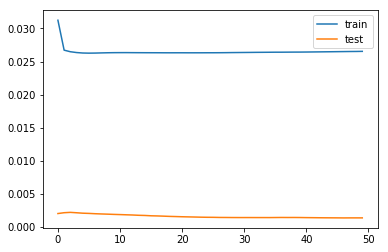

In [97]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [98]:
print test_stock_X, test_gap_X, test_fai_X
yhat =  model.predict([test_stock_X, test_gap_X, test_fai_X],batch_size=1,verbose=1)
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0], test_stock_X.shape[2]))
test_gap_X = test_gap_X.reshape((test_gap_X.shape[0], test_gap_X.shape[2]))
test_fai_X = test_fai_X.reshape((test_fai_X.shape[0], test_fai_X.shape[2]))
print test_stock_X, test_gap_X, test_fai_X



[[[ 0.56146789]]

 [[ 0.50825691]]

 [[ 0.51009172]]

 [[ 0.50091743]]

 [[ 0.48440367]]] [[[ 0.22009568]]

 [[ 0.48803827]]

 [[ 0.40669855]]

 [[ 0.35406697]]

 [[ 0.56459326]]] [[[ 0.58260864]]

 [[ 0.58260864]]

 [[ 0.58260864]]

 [[ 0.58260864]]

 [[ 0.58260864]]]
1/5 [=====>........................] - ETA: 1s[[ 0.56146789]
 [ 0.50825691]
 [ 0.51009172]
 [ 0.50091743]
 [ 0.48440367]] [[ 0.22009568]
 [ 0.48803827]
 [ 0.40669855]
 [ 0.35406697]
 [ 0.56459326]] [[ 0.58260864]
 [ 0.58260864]
 [ 0.58260864]
 [ 0.58260864]
 [ 0.58260864]]


In [143]:
#print yhat
print len(test_stock_y)
#yhat = yhat.reshape((len(test_stock_y), 1))
yhat = np.array(yhat)
yhat = yhat.reshape((len(test_stock_y), 1))
print yhat.shape
#print [test_stock_X,test_gap_X, test_fai_X]
#print [test_stock_X[:,1:],test_gap_X[:,1:], test_fai_X[:,1:]]
#test_stock_X_p = test_stock_X[0:].reshape(-1, 1)
#test_gap_X_p = test_gap_X[0:].reshape(-1, 1)
#test_fai_X_p = test_fai_X[0:].reshape(-1, 1)
#print test_stock_X_p, test_gap_X_p, test_fai_X_p

inv_yhat = concatenate((yhat, [[test_stock_X,test_gap_X, test_fai_X]]), axis=1)
print inv_yhat
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_stock_y = test_stock_y.reshape((len(test_stock_y), 1))
inv_y = concatenate((test_stock_y, test_stock_X[:, 1:]), axis =1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

5


ValueError: cannot reshape array of size 15 into shape (5,1)

In [138]:
#inv_yhat = concatenate((yhat, test_stock_X[:, 1:]), axis=1)
#print inv_yhat
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
#test_stock_X = test_stock_X.reshape((len(test_stock_X), 1))

#inv_yhat = concatenate((yhat, test_stock_X[:, 1:]), axis=1)
#print inv_yhat
#inv_yhat = inv_yhat[:,0]
test_stock_y = test_stock_y.reshape((len(test_stock_y), 1))
print test_stock_y
inv_y = concatenate((test_stock_y, test_stock_X[:, 1:]), axis =1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

[[ 0.50825691]
 [ 0.51009172]
 [ 0.50091743]
 [ 0.48440367]
 [ 0.49541286]]
